## CLASSIFICATION OF PARKISON'S DISEASE DATA

Equipe :
    * Jéssica Villar - 1613176
    * Fernando Tancini - 1711799
    * Andrea Mourelo - 1820000

# Considerações iniciais

A ideia deste trabalho é de encontrar um modelo que permita prever se um paciente dado vai ter Parkinson ou nao.

Para isso, vamos usar o dataset 'parkinsons.data' que se encontra no link: https://archive.ics.uci.edu/ml/machine-learning-databases/parkinsons/

Nesse link encontramos a descriçao do dataset: 'This dataset is composed of a range of biomedical voice measurements from 31 people, 23 with Parkinson's disease (PD). Each column in the table is a particular voice measure, and each row corresponds one of 195 voice recording from these individuals ("name" column). The main aim of the data is to discriminate healthy people from those with PD, according to "status" column which is set to 0 for healthy and 1 for PD. '


Ao longo deste trabalho, vamos tentar encontrar um modelo preditivo variando:
* Primeiro, o número de linhas usadas desse dataset: o dataset inteiro ou um dataset equilibrado
* Depois, o número e tipo de features usadas no modelo: todas as features, a metade ou as mais significativas, etc.
* Também, nosso trabalho vai variar os modelos usados: kNN, SVM ou Decision Trees
* Finalmente, variaremos as configurações dos algoritmos: kNN será usado com o parâmetro de vizinhos entre 1 e 6 e a altura dos decision trees variará entre 2 e 7


Para fazer a análise dos resultados, vamos considerar que o melhor modelo é o que tem uma acurácia:
* média o mais alta possível
* tentando que a mediana seja também elevada
* e que o primeiro quartil esteja acima de 0,8

Além disso, gostaríamos também de ter um recall o mais elevado possível, pois nesse caso médico, os pacientes considerados 'False Negatives' são de extrema importância e teriam que ser quase nulos no melhor modelo.

Para fazer este trabalho acadêmico e para obter sempre os mesmos resultados, vamos definir uma seed e usá-la ao longo do nosso trabalho.

# Set up

In [1]:
import pandas as pd
import numpy as np

# Bibliotecas e funções de visualização e ML
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import svm
from sklearn import metrics

%matplotlib inline 
plt.style.use('seaborn-whitegrid')
plt.rc('font', family='Arial')
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('font', size=20) 
plt.rc('figure', figsize = (12, 5))

In [2]:
# Função usada para o set up da seed a cada função, pois se não não funcionava
def set_seed():
    # Set a seed value: 
    seed_value = 1001004  
    # 1. Set PYTHONHASHSEED environment variable at a fixed value: 
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value) 
    # 2. Set python built-in pseudo-random generator at a fixed value:
    import random
    random.seed(seed_value) 
    # 3. Set numpy pseudo-random generator at a fixed value:
    np.random.seed(seed_value) 

# Parkinson's Data

Damos uma olhada nos dados

In [3]:
filename = 'parkinsons.data'
dfParkinson = pd.read_csv(filename)
dfParkinson.head()

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [4]:
outcome_column = 'status'
# status: 0: healthy, 1: Parkinson's
outcome_labels = {0: 'healthy', 1:'Parkinson`s'}
label_counts = np.bincount(dfParkinson.status)
print(label_counts)

[ 48 147]


Podemos ver que temos mais dados de pacientes com Parkinsons do que sem. Por enquanto, vamos usar todos os dados para análise mais no final do trabalho vamos somente pegar um dataset equilibrado.

# Funções usadas ao longo do trabalho

In [5]:
# Definimos uma função que, a partir de um df, uma lista e um número de features, uma porcentagem PRC,
# um inteiro numModelos, e uns titulos,
# cria varios modelos (13 modelos variando parâmetros de kNN,SVM e Decision Trees) com PRC % de dados de teste
# com cada modelo sendo testado numModelos vezes
# retorna as acuracias, precisions, recalls e f1_scores de cada modelo
# e plota os BoxPlot dos diferentes modelos

def modelos(df, features, nFeatures, PRC, numModelos, titles):
    # Reusamos a função de seed, se não não funciona...
    seed_value = 1001004  
    import os
    os.environ['PYTHONHASHSEED']=str(seed_value) 
    import random
    random.seed(seed_value) 
    np.random.seed(seed_value) 
    
    # Vamos a guardar as acurácias, precision, recall e f1_score de todos os modelos
    # Essas listas terão nFeatures objetos cada uma
    acuracias = []
    precisions = []
    recalls = []
    f1_scores = []

    # Aplicamos 13 modelos a esses nFeatures tipos de dados
    for j in range(nFeatures):
        # convertemos feature dataframe e label series para arrays
        X = np.array(df[features[j]]) # X = array de dados dos pacientes
        Y = np.array(df[outcome_column]) # Y = outcome "status" dos pacientes

        # vamos chamar essa loop numModelos vezes, criando 13 models a cada vez
        acc_r=np.zeros((numModelos,13))
        precision_r=np.zeros((numModelos,13))
        recall_r=np.zeros((numModelos,13))
        f1_score_r=np.zeros((numModelos,13))

        # numModelos iterações
        for i in range(numModelos):
            # Controlamos que os valores sejam sempre os mesmos (com uma seed),
            # Mas cada iteração deve ter dados diferentes para nao obter sempre a mesma accuracy
            seed = seed_value + i*1200 
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=PRC,random_state = seed)

            # configuramos 13 tipos de modelos
            nn1 = neighbors.KNeighborsClassifier(n_neighbors=1) # kNN com 1 vizinho
            nn2 = neighbors.KNeighborsClassifier(n_neighbors=2) # kNN com 2 vizinhos
            nn3 = neighbors.KNeighborsClassifier(n_neighbors=3) # kNN com 3 vizinhos
            nn4 = neighbors.KNeighborsClassifier(n_neighbors=4) # kNN com 4 vizinhos
            nn5 = neighbors.KNeighborsClassifier(n_neighbors=5) # kNN com 5 vizinhos
            nn6 = neighbors.KNeighborsClassifier(n_neighbors=6) # kNN com 6 vizinhos
            svc = svm.SVC(gamma='auto') # SVM
            dt2 = tree.DecisionTreeClassifier(max_depth = 2) # Decision Tree de altura 2
            dt3 = tree.DecisionTreeClassifier(max_depth = 3) # Decision Tree de altura 3
            dt4 = tree.DecisionTreeClassifier(max_depth = 4) # Decision Tree de altura 4
            dt5 = tree.DecisionTreeClassifier(max_depth = 5) # Decision Tree de altura 5
            dt6 = tree.DecisionTreeClassifier(max_depth = 6) # Decision Tree de altura 6
            dt7 = tree.DecisionTreeClassifier(max_depth = 7) # Decision Tree de altura 7

            # treinamos cada modelo
            nn1.fit(X_train,Y_train)
            nn2.fit(X_train,Y_train)
            nn3.fit(X_train,Y_train)
            nn4.fit(X_train,Y_train)
            nn5.fit(X_train,Y_train)
            nn6.fit(X_train,Y_train)
            svc.fit(X_train,Y_train)
            dt2.fit(X_train,Y_train)
            dt3.fit(X_train,Y_train)
            dt4.fit(X_train,Y_train)
            dt5.fit(X_train,Y_train)
            dt6.fit(X_train,Y_train)
            dt7.fit(X_train,Y_train)

            # testamos cada modelo
            Yhat_nn1=nn1.predict(X_test)
            Yhat_nn2=nn2.predict(X_test)
            Yhat_nn3=nn3.predict(X_test)
            Yhat_nn4=nn4.predict(X_test)
            Yhat_nn5=nn5.predict(X_test)
            Yhat_nn6=nn6.predict(X_test)
            Yhat_svc=svc.predict(X_test)
            Yhat_dt2=dt2.predict(X_test)
            Yhat_dt3=dt3.predict(X_test)
            Yhat_dt4=dt4.predict(X_test)
            Yhat_dt5=dt5.predict(X_test)
            Yhat_dt6=dt6.predict(X_test)
            Yhat_dt7=dt7.predict(X_test)

            # acurácia de cada modelo nessa iteração
            acc_r[i][0] = metrics.accuracy_score(Yhat_nn1, Y_test)
            acc_r[i][1] = metrics.accuracy_score(Yhat_nn2, Y_test)
            acc_r[i][2] = metrics.accuracy_score(Yhat_nn3, Y_test)
            acc_r[i][3] = metrics.accuracy_score(Yhat_nn4, Y_test)
            acc_r[i][4] = metrics.accuracy_score(Yhat_nn5, Y_test)
            acc_r[i][5] = metrics.accuracy_score(Yhat_nn6, Y_test)
            acc_r[i][6] = metrics.accuracy_score(Yhat_svc, Y_test)
            acc_r[i][7] = metrics.accuracy_score(Yhat_dt2, Y_test)
            acc_r[i][8] = metrics.accuracy_score(Yhat_dt3, Y_test)
            acc_r[i][9] = metrics.accuracy_score(Yhat_dt4, Y_test)
            acc_r[i][10] = metrics.accuracy_score(Yhat_dt5, Y_test)
            acc_r[i][11] = metrics.accuracy_score(Yhat_dt6, Y_test)
            acc_r[i][12] = metrics.accuracy_score(Yhat_dt7, Y_test)

            # precision de cada modelo nessa iteração
            precision_r[i][0] = metrics.precision_score(Yhat_nn1, Y_test)
            precision_r[i][1] = metrics.precision_score(Yhat_nn2, Y_test)
            precision_r[i][2] = metrics.precision_score(Yhat_nn3, Y_test)
            precision_r[i][3] = metrics.precision_score(Yhat_nn4, Y_test)
            precision_r[i][4] = metrics.precision_score(Yhat_nn5, Y_test)
            precision_r[i][5] = metrics.precision_score(Yhat_nn6, Y_test)
            precision_r[i][6] = metrics.precision_score(Yhat_svc, Y_test)
            precision_r[i][7] = metrics.precision_score(Yhat_dt2, Y_test)
            precision_r[i][8] = metrics.precision_score(Yhat_dt3, Y_test)
            precision_r[i][9] = metrics.precision_score(Yhat_dt4, Y_test)
            precision_r[i][10] = metrics.precision_score(Yhat_dt5, Y_test)
            precision_r[i][11] = metrics.precision_score(Yhat_dt6, Y_test)
            precision_r[i][12] = metrics.precision_score(Yhat_dt7, Y_test)

            # recall de cada modelo nessa iteração
            recall_r[i][0] = metrics.recall_score(Yhat_nn1, Y_test)
            recall_r[i][1] = metrics.recall_score(Yhat_nn2, Y_test)
            recall_r[i][2] = metrics.recall_score(Yhat_nn3, Y_test)
            recall_r[i][3] = metrics.recall_score(Yhat_nn4, Y_test)
            recall_r[i][4] = metrics.recall_score(Yhat_nn5, Y_test)
            recall_r[i][5] = metrics.recall_score(Yhat_nn6, Y_test)
            recall_r[i][6] = metrics.recall_score(Yhat_svc, Y_test)
            recall_r[i][7] = metrics.recall_score(Yhat_dt2, Y_test)
            recall_r[i][8] = metrics.recall_score(Yhat_dt3, Y_test)
            recall_r[i][9] = metrics.recall_score(Yhat_dt4, Y_test)
            recall_r[i][10] = metrics.recall_score(Yhat_dt5, Y_test)
            recall_r[i][11] = metrics.recall_score(Yhat_dt6, Y_test)
            recall_r[i][12] = metrics.recall_score(Yhat_dt7, Y_test)

            # f1_score de cada modelo nessa iteração
            f1_score_r[i][0] = metrics.f1_score(Yhat_nn1, Y_test)
            f1_score_r[i][1] = metrics.f1_score(Yhat_nn2, Y_test)
            f1_score_r[i][2] = metrics.f1_score(Yhat_nn3, Y_test)
            f1_score_r[i][3] = metrics.f1_score(Yhat_nn4, Y_test)
            f1_score_r[i][4] = metrics.f1_score(Yhat_nn5, Y_test)
            f1_score_r[i][5] = metrics.f1_score(Yhat_nn6, Y_test)
            f1_score_r[i][6] = metrics.f1_score(Yhat_svc, Y_test)
            f1_score_r[i][7] = metrics.f1_score(Yhat_dt2, Y_test)
            f1_score_r[i][8] = metrics.f1_score(Yhat_dt3, Y_test)
            f1_score_r[i][9] = metrics.f1_score(Yhat_dt4, Y_test)
            f1_score_r[i][10] = metrics.f1_score(Yhat_dt5, Y_test)
            f1_score_r[i][11] = metrics.f1_score(Yhat_dt6, Y_test)
            f1_score_r[i][12] = metrics.f1_score(Yhat_dt7, Y_test)

        acuracias.append(acc_r)
        precisions.append(precision_r)
        recalls.append(recall_r)
        f1_scores.append(f1_score_r)

        # Plot
        plt.figure(figsize=(15,6))
        plt.boxplot(acc_r)
        for i in range(13):
            xderiv = (i+1) * np.ones(acc_r[:,i].shape) + (np.random.rand(10,)-0.5) * 0.1
            plt.plot(xderiv, acc_r[:,i], 'ro', alpha=0.3)
        ax = plt.gca()
        ax.set_xticklabels(['1-NN', '2-NN','3-NN', '4-NN','5-NN', '6-NN','SVM',
                            'DT2','DT3','DT4','DT5','DT6','DT7'])
        plt.ylabel('Acuracia')
        ax.set_title(titles[j])
        plt.show()
        #plt.savefig('figs/error_ms_1.png',dpi=300, bbox_inches='tight')    return acuracias, precisions, recalls, f1_scores
    
    return acuracias, precisions, recalls, f1_scores

In [6]:
# Definimos uma função que, depois de executar a função anterior, vai plotar um heatmap
# A ideia é que num_modelo é um inteiro entre 0 e numFeatures

def analise_modelos_obtidos(num_modelo, titulo):
    models = ['1-NN', '2-NN','3-NN', '4-NN','5-NN', '6-NN','SVM','DT2','DT3','DT4','DT5','DT6','DT7']
    
    # Usamos os arrays retornados pela função anterior
    acuracias_num = pd.DataFrame(acuracias[num_modelo])
    precisions_num = pd.DataFrame(precisions[num_modelo])
    recalls_num = pd.DataFrame(recalls[num_modelo])
    f1_scores_num = pd.DataFrame(f1_scores[num_modelo])
    acuracias_num.columns, precisions_num.columns = models, models
    recalls_num.columns, f1_scores_num.columns = models, models
    
    # Ver um pouco mais tarde no projeto um exemplo para visualizar esse df análise
    analise = pd.DataFrame(acuracias_num.mean(), columns = ['Accuracy'])
    analise['Precision'] = pd.DataFrame(precisions_num.mean())
    analise['Recall'] = pd.DataFrame(recalls_num.mean())
    analise['F1_Score'] = pd.DataFrame(f1_scores_num.mean())
    analise = analise.T
    
    # Plot
    sns.set(font_scale=1.2)
    plt.figure(figsize=(20,20))
    plt.title(titulo)
    vMeio = (analise[:1].min().min() + analise[:1].max().max())/2  # Para as cores serem centradas no valor medio das accuracies
    sns.heatmap(analise, annot=True, square=True, cbar=False, fmt=".3f", linewidths=0.95, cmap='Greens', vmin = vMeio)

# Primeiros Modelos

As primeiras 11 features, escolhidas aleatoriamente, são:
['MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'NHR', 'HNR', 'spread1', 'D2', 'PPE']

As outras 11 features são:
['MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:APQ', 'Shimmer:DDA', 'RPDE', 'DFA', 'spread2']


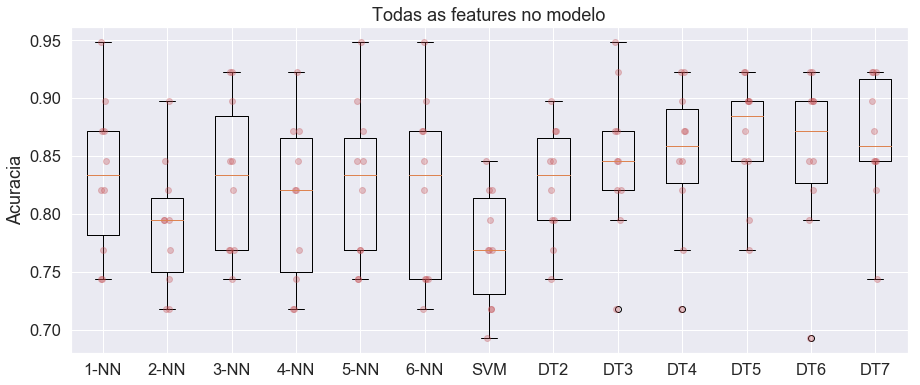

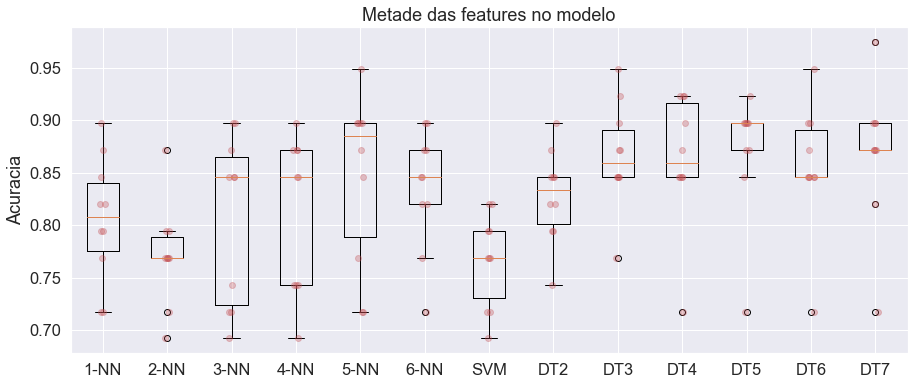

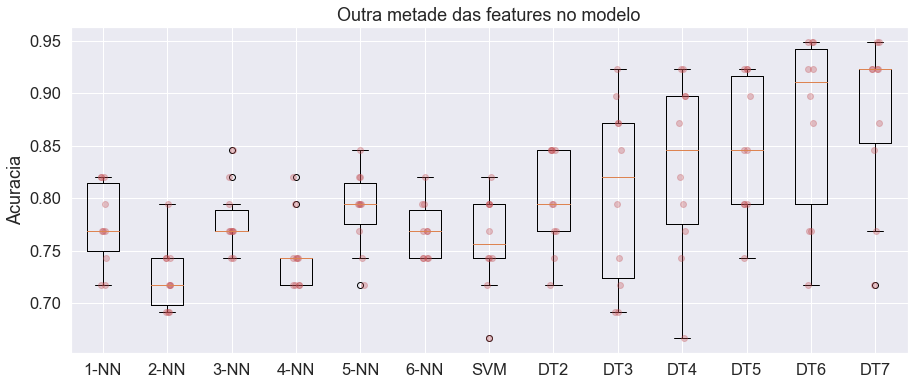

In [7]:
set_seed()
sns.set(font_scale=1.5)

# Selecionamos todas as colunas como features, menos 'name' e 'status', essa última sendo nosso target.
features_all = [col for col in dfParkinson.columns if col not in ['name', 'status']]

# Selecionamos aleatoriamente metade das colunas
features_half = []
features_other_half = []
num_columns = len(features_all)
random_columns = sorted(random.sample(range(0, num_columns), int(num_columns/2)))
for i in range(len(features_all)):
    if (i in random_columns): 
        features_half.append(features_all[i])
    else : 
        features_other_half.append(features_all[i])

print('As primeiras 11 features, escolhidas aleatoriamente, são:')
print(features_half)
print('\n' + 'As outras 11 features são:')
print(features_other_half)

# Chamamos nossa função de modelo
features = [features_all, features_half, features_other_half]
PRC = 0.2  # 20% de teste
titles = ["Todas as features no modelo","Metade das features no modelo","Outra metade das features no modelo"]
acuracias, precisions, recalls, f1_scores = modelos(dfParkinson,features,len(features),PRC, 10, titles)

A primeira coisa a se observar é a grande variação dos resultados dos modelos ao selecionar diferentes features. Efetivamente, as distribuições em geral variam muito, mas as distribuições para um mesmo tipo de modelo também.

Além disso, podemos dizer que:

* Quando todas as features são consideradas, o modelo com a melhor acurácia em mediana é o Decision Tree com altura 5. Além disso, o primeiro quartil é quase o mais elevado, o que mostra que a distribuição é bem homogênea.

* Enquanto isso, quando as primeiras 11 features são escolhidas aleatoriamente, o modelo com melhor acurácia em mediana segue sendo o DT5. Nesse caso, o segundo e terceiro quartil são iguais, o que mostra que a distribuição é ainda mais homogênea, pois temos muitas acurácias concentradas em 0.9 (quase). Também, observamos que a acurácia mínima desse modelo é menor do que a acurácia mínima do DT5 no caso anterior, mas a acurácia do primeiro quartil é maior.

* Ao escolher outras 11 features, o modelo com melhor acurácia em mediana passa a ser o DT com altura 7. Nesse caso, a acurácia mediana é maior do que nos outros dois "melhores" modelos anteriores (0.92 ao invés de 0.9 ou menos), mas a distribuição é muito mais heterogênea. 

## Análise das médias das accuracy, precision, recall e f1_score

Vamos plotar as matrizes obtidas por modelo para entender

In [8]:
models = ['1-NN', '2-NN','3-NN', '4-NN','5-NN', '6-NN','SVM','DT2','DT3','DT4','DT5','DT6','DT7']

acuracias_all = pd.DataFrame(acuracias[0])
precisions_all = pd.DataFrame(precisions[0])
recalls_all = pd.DataFrame(recalls[0])
f1_scores_all = pd.DataFrame(f1_scores[0])
acuracias_all.columns, precisions_all.columns = models, models
recalls_all.columns, f1_scores_all.columns = models, models

# Só para entender, print de acuracias_all:
acuracias_all
# As colunas representam os modelos e as linhas as iterações feitas (com dados de testes diferentes)

,1-NN,2-NN,3-NN,4-NN,5-NN,6-NN,SVM,DT2,DT3,DT4,DT5,DT6,DT7
0,0.871795,0.794872,0.897436,0.846154,0.846154,0.871795,0.820513,0.820513,0.794872,0.923077,0.923077,0.923077,0.923077
1,0.897436,0.846154,0.846154,0.871795,0.820513,0.820513,0.769231,0.846154,0.871795,0.871795,0.897436,0.897436,0.871795
2,0.769231,0.717949,0.769231,0.717949,0.743590,0.743590,0.717949,0.846154,0.846154,0.846154,0.846154,0.846154,0.846154
3,0.743590,0.717949,0.769231,0.717949,0.769231,0.717949,0.769231,0.794872,0.820513,0.769231,0.794872,0.820513,0.846154
4,0.820513,0.769231,0.923077,0.871795,0.897436,0.897436,0.846154,0.897436,0.923077,0.871795,0.923077,0.897436,0.923077
5,0.743590,0.794872,0.743590,0.769231,0.769231,0.743590,0.717949,0.769231,0.717949,0.717949,0.769231,0.692308,0.743590
6,0.948718,0.897436,0.923077,0.923077,0.948718,0.948718,0.820513,0.743590,0.820513,0.820513,0.871795,0.794872,0.846154
7,0.820513,0.820513,0.769231,0.743590,0.743590,0.743590,0.692308,0.794872,0.846154,0.846154,0.846154,0.846154,0.820513
8,0.846154,0.794872,0.820513,0.820513,0.846154,0.846154,0.769231,0.871795,0.948718,0.897436,0.897436,0.897436,0.897436
9,0.871795,0.743590,0.846154,0.820513,0.871795,0.871795,0.794872,0.871795,0.871795,0.923077,0.897436,0.923077,0.923077


In [9]:
# Só pra entender de onde vem o heatmap depois:
analise = pd.DataFrame(acuracias_all.mean(), columns = ['Accuracy'])
analise['Precision'] = pd.DataFrame(precisions_all.mean())
analise['Recall'] = pd.DataFrame(recalls_all.mean())
analise['F1_Score'] = pd.DataFrame(f1_scores_all.mean())
analise = analise.T
analise

,1-NN,2-NN,3-NN,4-NN,5-NN,6-NN,SVM,DT2,DT3,DT4,DT5,DT6,DT7
Accuracy,0.833333,0.789744,0.830769,0.810256,0.825641,0.820513,0.771795,0.825641,0.846154,0.848718,0.866667,0.853846,0.864103
Precision,0.874122,0.782672,0.906488,0.869113,0.937835,0.907074,1.000000,0.958711,0.925618,0.935165,0.938380,0.931807,0.938512
Recall,0.904050,0.930019,0.871595,0.875270,0.846942,0.861546,0.767848,0.833231,0.877716,0.873081,0.890507,0.882060,0.888408
F1_Score,0.886714,0.847226,0.888015,0.871459,0.888898,0.882692,0.867865,0.891079,0.899839,0.901661,0.912287,0.904396,0.911076


E agora mostrar os resultados (todo sao médias das 10 iterações de cada modelo)

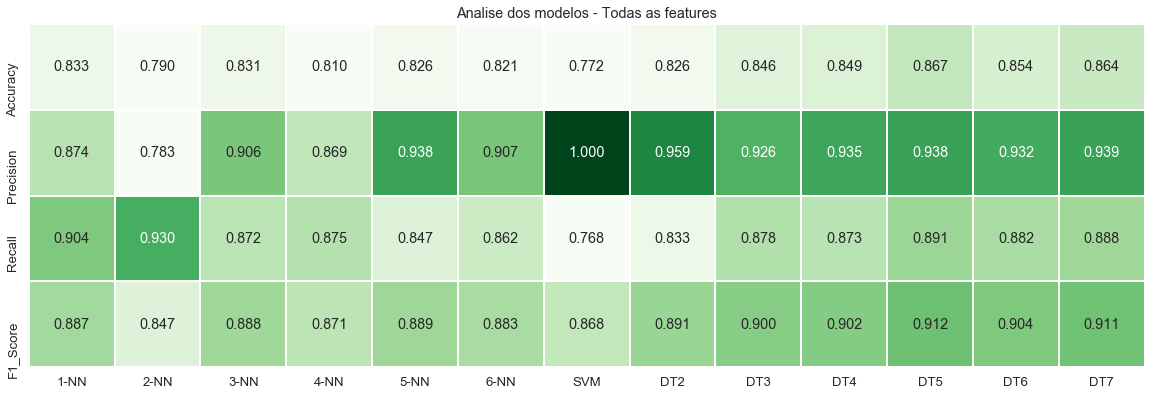

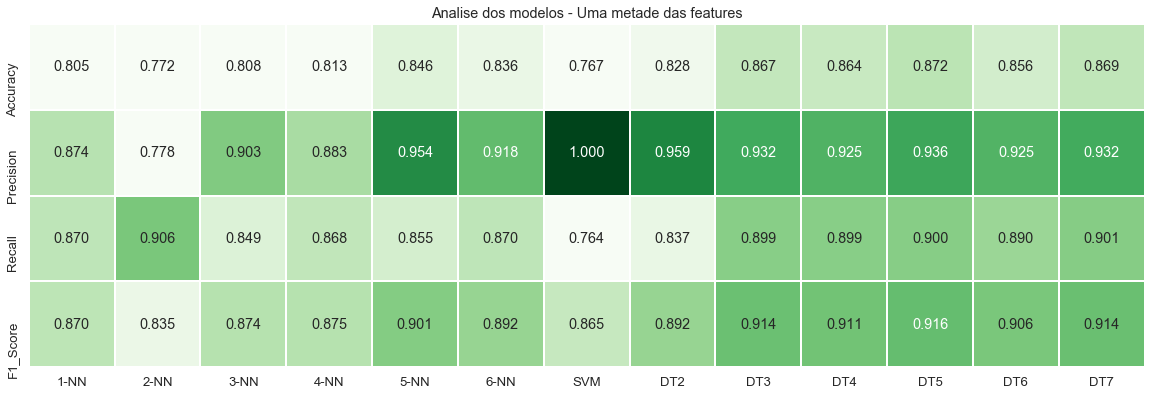

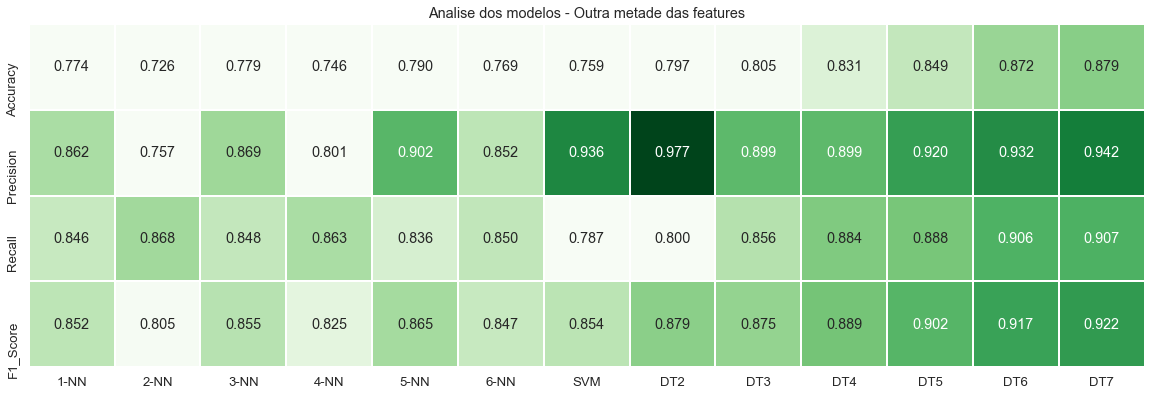

In [10]:
analise_modelos_obtidos(0,'Analise dos modelos - Todas as features')
analise_modelos_obtidos(1,'Analise dos modelos - Uma metade das features')
analise_modelos_obtidos(2,'Analise dos modelos - Outra metade das features')

A primeira coisa que podemos observar é que, nos 3 casos, as maiores acurácias médias são obtidas com os Decision Trees. A melhor acurácia média é obtida com o Decision Tree de altura 7 e a segunda metade das features.

Porém, a maior Precision é obtida com o modelo SVM e a primeira metade das features ou todas as features. Esse resultado é igual a 1, o que pode ser considerado como overfitting pois é bastante raro. Esse overfitting faz sentido se pensamos que a grande maioria dos nossos dados são pacientes com valor 'true' (tendo Parkinson).

Como foi dito acima, nesse estudo especificamente, o recall é muito importante, pois quanto menos FN, mais o recall melhora. Observamos que o melhor recall é obtido com o modelo 2-NN usando todas as features (0.930), mas o recall do Decision Tree de altura 7 com a segunda metade das features já é bem bom (0.907).

Finalmente, o F1_score, medida de avaliação do modelo, é maior no modelo Decision Tree de altura 7 com a segunda metade das features (0.922).

Em conclusão, parece que esse modelo Decision Tree de altura 7 com a segunda metade das features (['MDVP:Fo(Hz)', 'MDVP:Jitter(Abs)', 'MDVP:RAP', 'MDVP:PPQ', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:APQ', 'Shimmer:DDA', 'RPDE', 'DFA', 'spread2']) seria o melhor modelo se tivermos que usar os valores médios.

Porém, o Decision Tree de altura 5 com a primeira metade das features (['MDVP:Fhi(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Jitter(%)', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'NHR', 'HNR', 'spread1', 'D2', 'PPE'])parece ter uma melhor distribuição das acurácias e uns bons valores para f1_score e recall (> 0.9). 

Agora, vamos tentar observar quais são as variáveis que tem maior correlação com o 'status' e criar novos modelos para conferer se ao escolher melhores features, teremos melhores resultados.

# Análise da correlação entre features

## Qual a correlação do 'status' (variável a ser predita) com as outras variáveis?

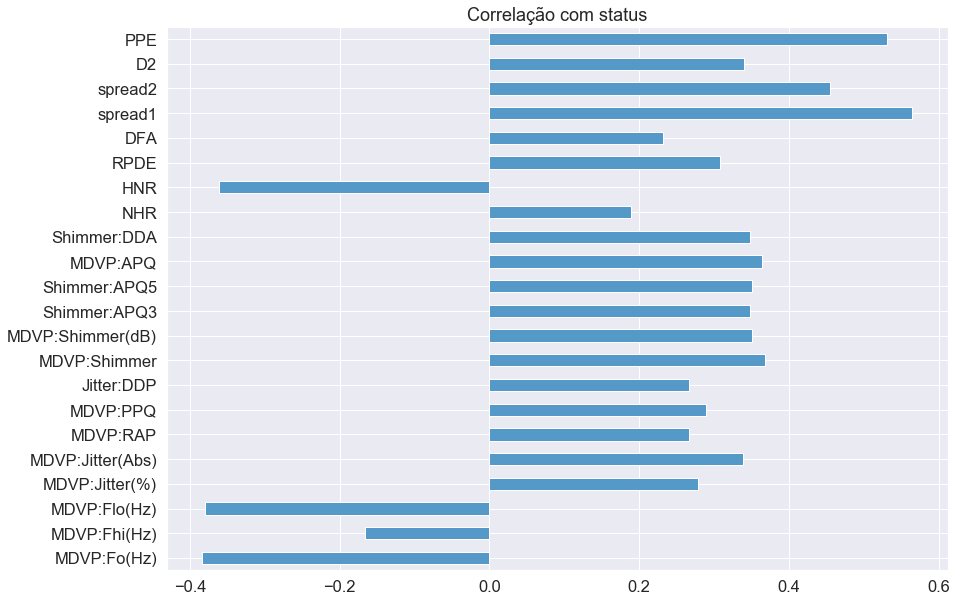

In [11]:
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn import tree
from sklearn import svm
from sklearn import metrics

set_seed()

# Calculando a matriz de correlação
corr = dfParkinson.corr()

sns.set(font_scale=1.5)

# Analisando as correlações de 'status' com as outras variáveis
c = corr['status'].drop('status')
c.plot(kind='barh', title = 'Correlação com status', figsize = (14,10), color = '#5499C7', grid = True)

### Heatmap

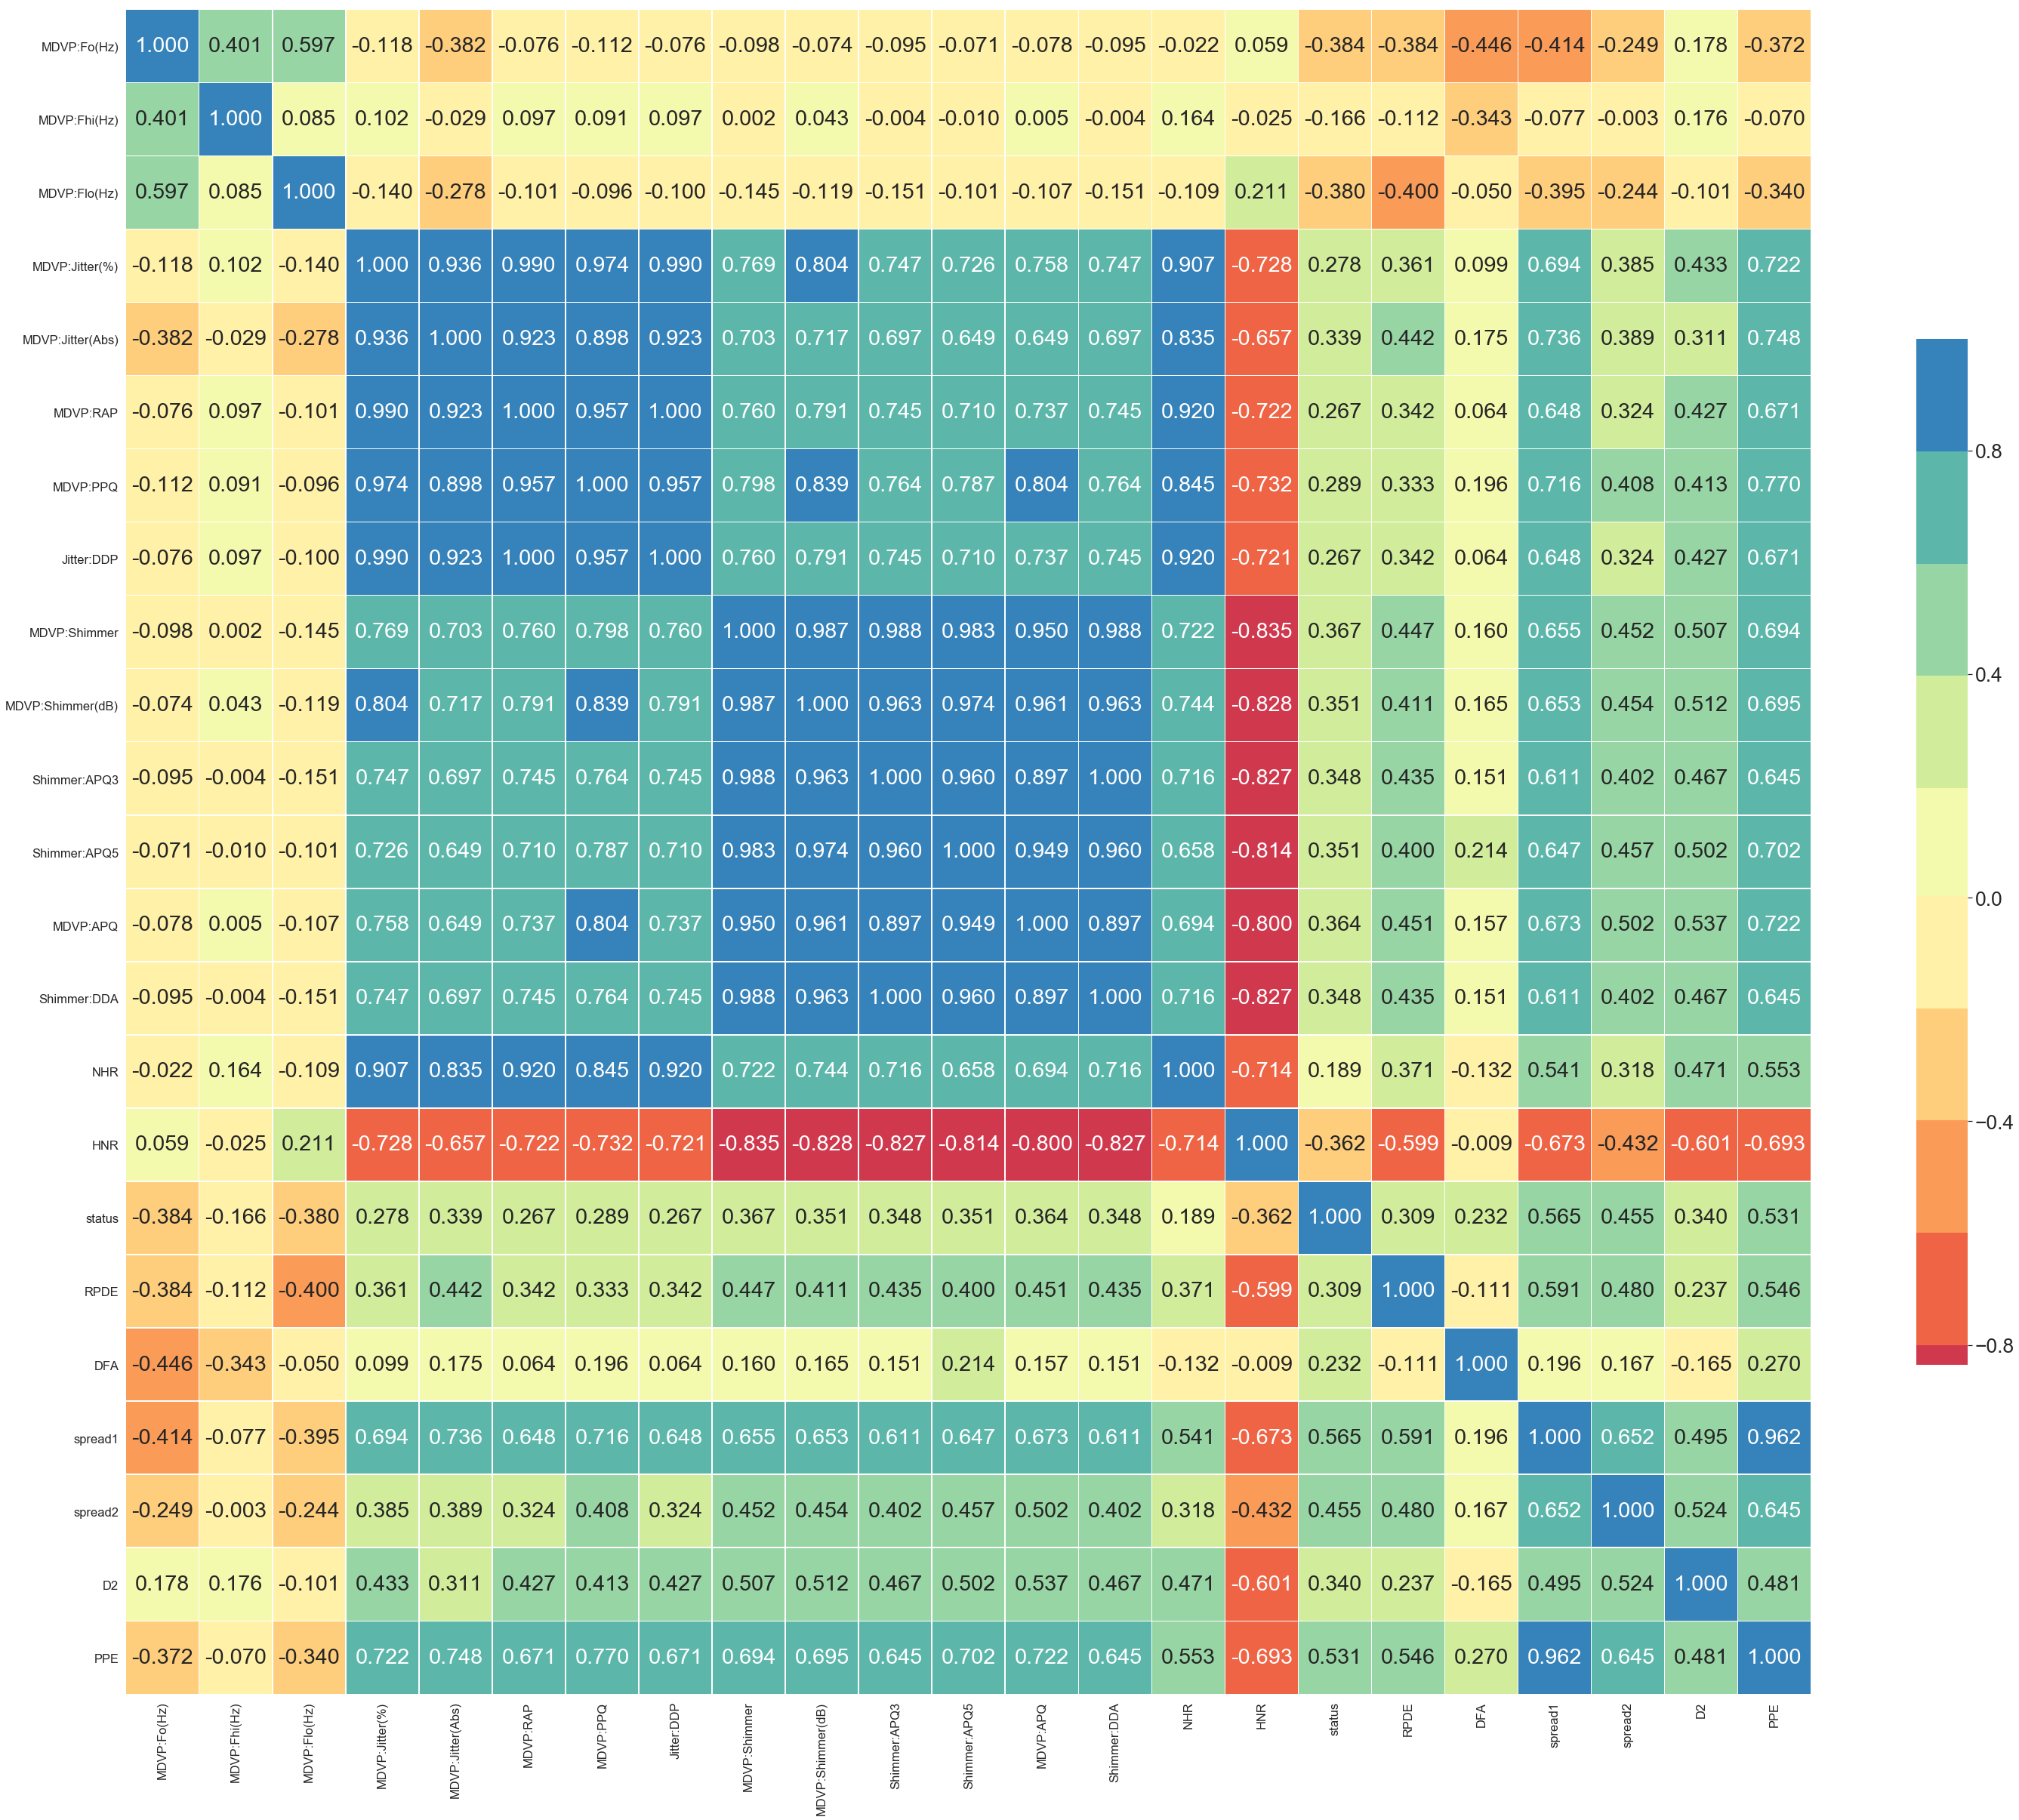

In [12]:
set_seed()

# Montando uma matriz de confusão com as correlações entre todas as variáveis
f, ax = plt.subplots(figsize=(50,50))
cmap = sns.color_palette("Spectral", 10)

sns.set(font_scale=2.4)

ax = sns.heatmap(corr, cmap=cmap, center=0, annot=True, fmt='.3f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Podemos observar que esse método corr() nos informa que as colunas que estão mais correlacionadas com o 'status' são:

* Correlação positiva : spread1, spread2 e PPE
* Correlação negativa : MDVP:Fo(Hz), MDVP:Flo(Hz) e HNR

### Feature importance

/Users/andreamourelo/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


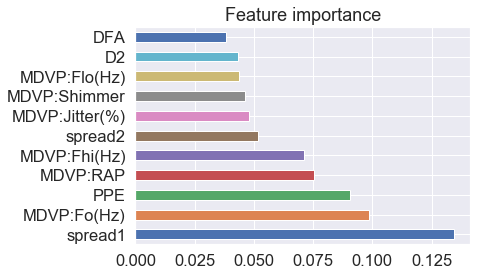

In [13]:
from sklearn.ensemble import ExtraTreesClassifier
sns.set(font_scale=1.5)

set_seed()

X = dfParkinson.drop('status',axis=1).iloc[:,1:]
y = dfParkinson['status']

model = ExtraTreesClassifier()
model.fit(X,y)

# plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(11).plot(kind='barh', title = 'Feature importance')
plt.show()

Essa classificação das features pelo ExtraTreesClassifier nos permite ver quais são as 11 features mais correlacionadas, segundo esse modelo, como o 'status'. Encontramos todas as features que o modelo anterior nos deu, mas com rankings diferentes.

Então, vamos fazer vários modelos tendo em conta esses resultados.

* O "Modelo com features de correlação positiva" vai usar todas as features com coeficiente positivo (no método corr())
* O "Modelo com as features de correlação negativa" vai usar todas as features com coeficiente negativo (no método corr())
* O "Modelo com features de maior correlação" vai usar todas as features com coeficiente alto (no método ExtraTreesClassifier())
* O "Modelo com features de maior correlação positiva" vai usar todas as features com coeficiente alto (no método ExtraTreesClassifier()), mas que são positivas no método corr()

# Outros modelos

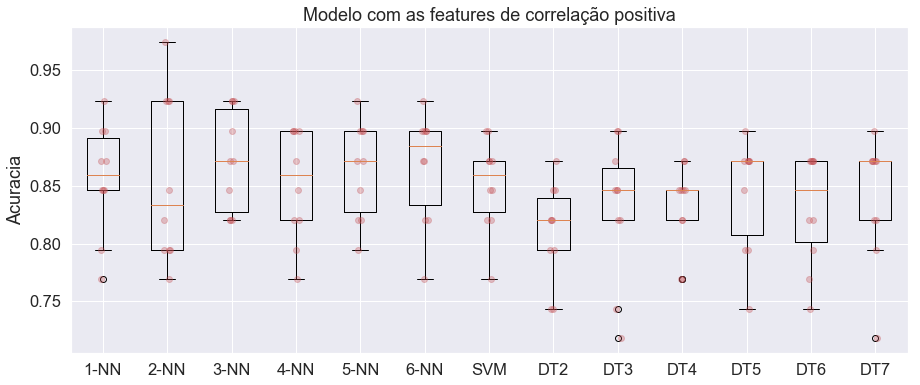

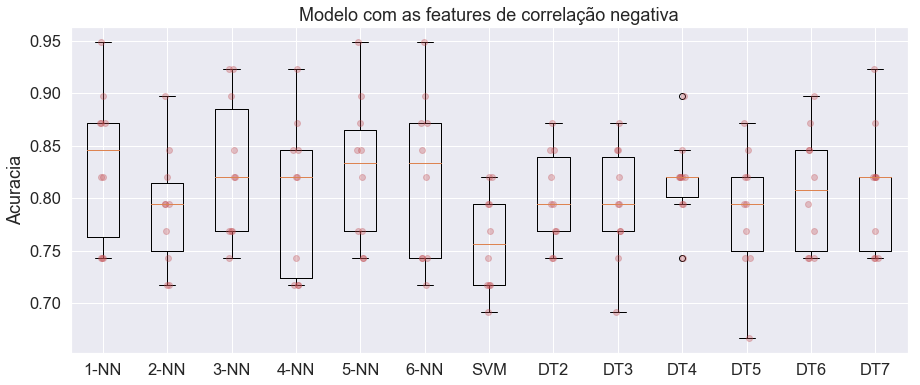

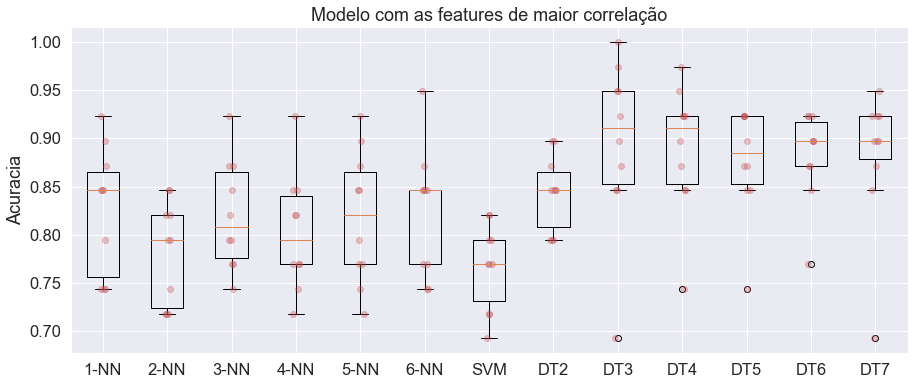

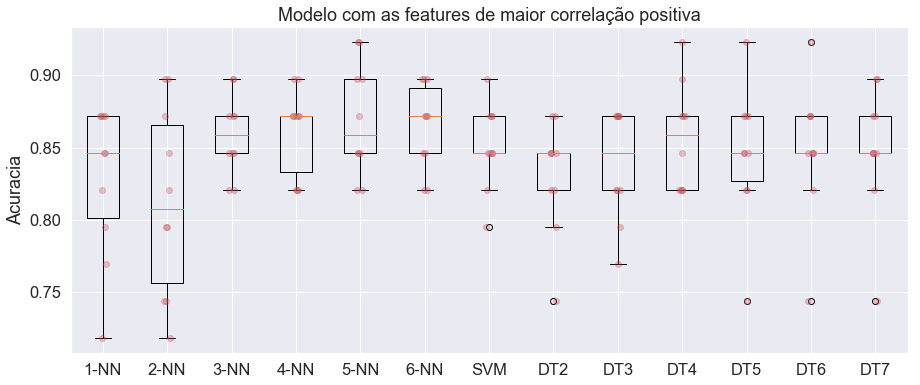

In [14]:
set_seed()
sns.set(font_scale=1.5)

# Selecionamos as colunas 
features_positive = [col for col in dfParkinson.columns if col not in ['name', 'status','HNR','MDVP:Fo(Hz)','MDVP:Flo(Hz)','MDVP:Fhi(Hz)']]
features_negative = [col for col in dfParkinson.columns if col in ['HNR','MDVP:Fo(Hz)','MDVP:Flo(Hz)','MDVP:Fhi(Hz)']]
features_max = [col for col in dfParkinson.columns if col in ['spread1','MDVP:Fo(Hz)','PPE','MDVP:RAP',
                                                              'MDVP:Fhi(Hz)','spread2','MDVP:Jitter(%)',
                                                              'MDVP:Shimer','MDVP:Flo(Hz)','D2','DFA']]
features_max_onlypositive = [col for col in dfParkinson.columns if col in ['spread1','PPE','MDVP:RAP',
                                                              'spread2','MDVP:Jitter(%)',
                                                              'MDVP:Shimer','D2','DFA']]
# Chamamos nossa função com os parâmetros
features = [features_positive,features_negative,features_max,features_max_onlypositive]
PRC = 0.2
titles = ["Modelo com as features de correlação positiva","Modelo com as features de correlação negativa",
         "Modelo com as features de maior correlação", "Modelo com as features de maior correlação positiva"]
acuracias, precisions, recalls, f1_scores = modelos(dfParkinson,features,len(features),PRC, 10, titles)

De novo observamos as grandes diferenças que existem entre os diferentes modelos ao ter features diferentes.

Além disso, podemos dizer que:

* Quando usamos todas as features com coeficiente positivo (no método corr()), o modelo tendo a melhor acurácia em mediana é o kNN com 6 vizinhos. Porém, a distribuição é bastante heterogênea, tendo alguns valores de acurácia abaixo de 0.8.

* Quando usamos todas as features com coeficiente negativo (no metodo corr()), o modelo tendo a melhor acuracia em mediana é o kNN com 1 vizinho. Porém, a distribuiçao é bastante heterogênea, tendo alguns valores por baixo de 0.75 de acuracia.

* Ao usar as features com coeficiente alto dadas pelo no método ExtraTreesClassifier(), obtemos que todos os modelos de Decision Trees têm acurácias medianas superiores ou iguais a 0.85. Para os DT com alturas superiores ou iguais a 3, temos acurácias medianas perto de 0.9, o que é muito bom, mas todos têm outliers inferiores a 0.8. O melhor compromisso parece ser o DT de altura 2, pois tem bons resultados e são bem homogêneos. 

* Finalmente, ao usar todas as features com coeficiente alto (no método ExtraTreesClassifier()), mas que são positivos no método corr(), obtemos modelos bons. O que têm a melhor acurácia mediana é o kNN com 6 vizinhos. A distribuição parece boa, pois é homogênea e com todos os resultados superiores a 0.8.

## Análise dos modelos obtidos

In [15]:
def analise_modelos_obtidos(num_modelo, titulo):
    models = ['1-NN', '2-NN','3-NN', '4-NN','5-NN', '6-NN','SVM','DT2','DT3','DT4','DT5','DT6','DT7']

    acuracias_num = pd.DataFrame(acuracias[num_modelo])
    precisions_num = pd.DataFrame(precisions[num_modelo])
    recalls_num = pd.DataFrame(recalls[num_modelo])
    f1_scores_num = pd.DataFrame(f1_scores[num_modelo])
    acuracias_num.columns, precisions_num.columns = models, models
    recalls_num.columns, f1_scores_num.columns = models, models
    
    analise = pd.DataFrame(acuracias_num.mean(), columns = ['Accuracy'])
    analise['Precision'] = pd.DataFrame(precisions_num.mean())
    analise['Recall'] = pd.DataFrame(recalls_num.mean())
    analise['F1_Score'] = pd.DataFrame(f1_scores_num.mean())
    analise = analise.T
    sns.set(font_scale=1.2)
    plt.figure(figsize=(20,20))
    plt.title(titulo)
    vMeio = (analise[:1].min().min() + analise[:1].max().max())/2  # Para as cores serem centradas no valor medio das accuracies
    sns.heatmap(analise, annot=True, square=True, cbar=False, fmt=".3f", linewidths=0.95, cmap='Greens', vmin = vMeio)
    

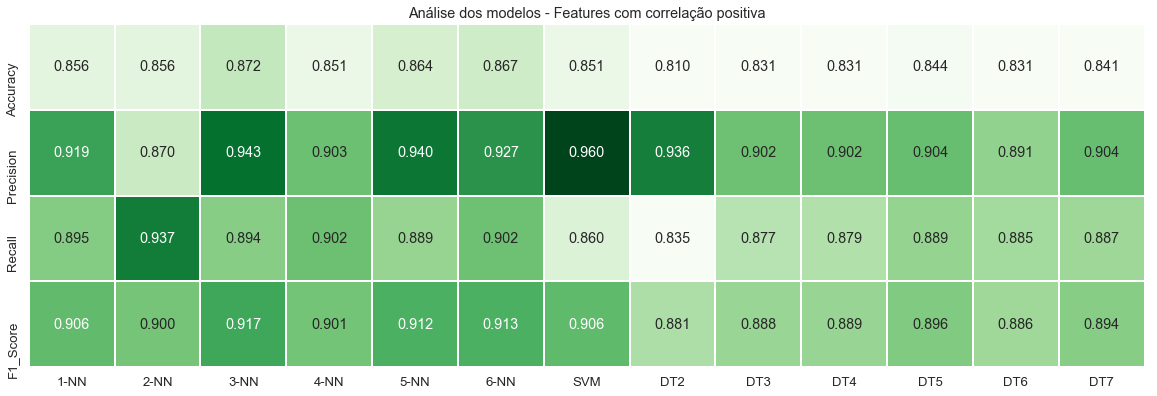

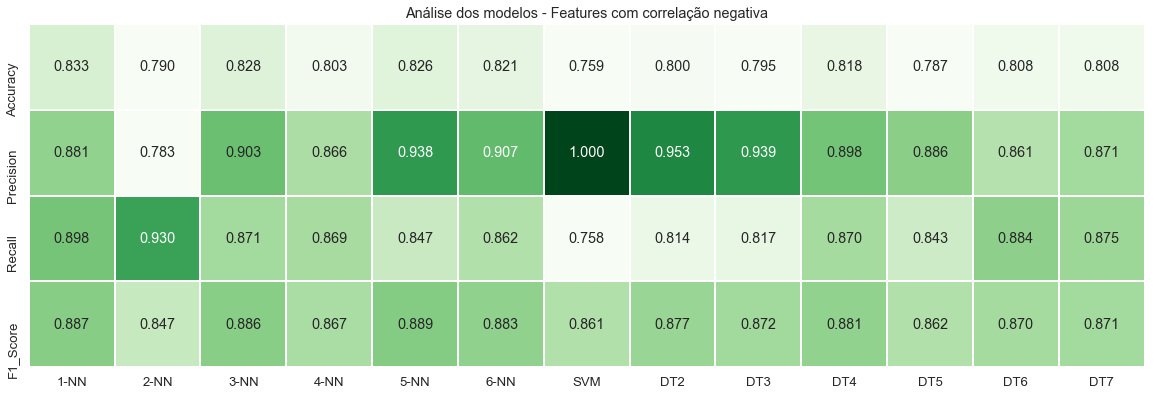

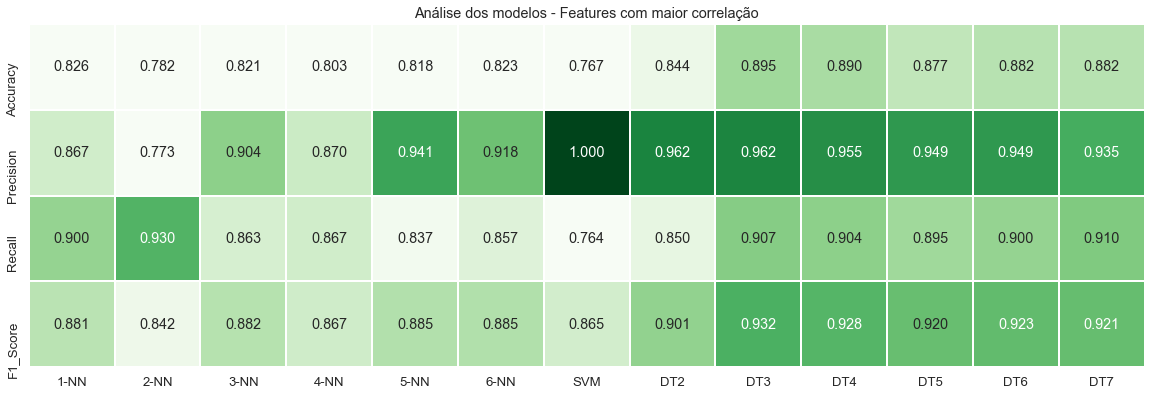

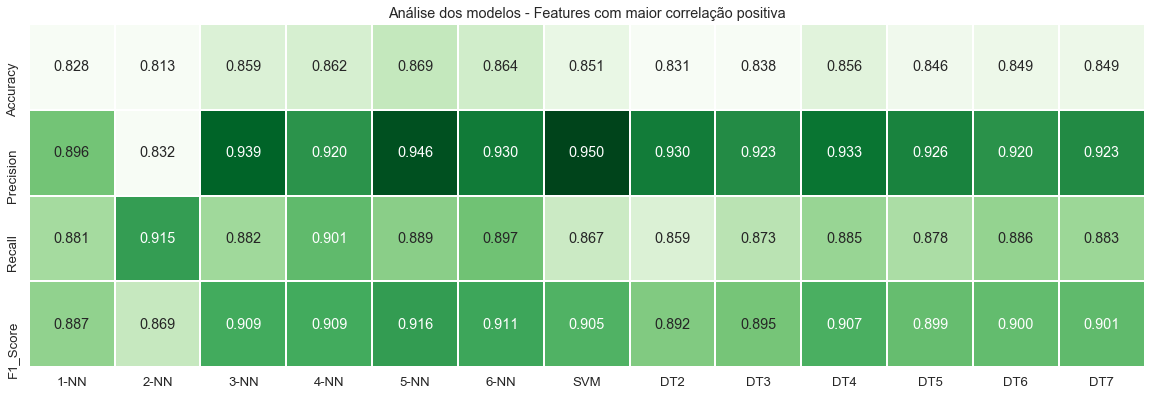

In [16]:
analise_modelos_obtidos(0,'Análise dos modelos - Features com correlação positiva')
analise_modelos_obtidos(1,'Análise dos modelos - Features com correlação negativa')
analise_modelos_obtidos(2,'Análise dos modelos - Features com maior correlação')
analise_modelos_obtidos(3,'Análise dos modelos - Features com maior correlação positiva')

A primeira coisa que podemos observar é que as maiores acurácias médias são obtidas com:
* O kNN com 3 vizinhos para as features com correlação positiva
* O kNN com 1 vizinho para as features com correlação negativa
* O DT de altura 3 para as features com maiores coeficientes obtidos pelo método ExtraTreesClassifier().
* O kNN com 5 vizinhos para as features com maiores coeficientes obtidos pelo método ExtraTreesClassifier() tendo coeficientes positivos no corr().

A melhor acurácia média (0.895) é obtida com o Decision Tree de altura 3 e as features com maiores coeficientes obtidos pelo metodo ExtraTreesClassifier(). Essa acurácia média é superior à maior média obtida na primeira parte do trabalho (0.879).

De novo, as maiores precisions são obtidas com o modelo SVM e isso segue fazendo sentido se pensamos que a grande maioria dos nossos dados são pacientes com valor 'true' (tendo Parkinson).

Observamos que o melhor recall é obtido com o modelo 2-NN usando as features com correlação positiva dadas pelo método corr() (0.937), mas os recall do Decision Tree de altura 3 e as features com maiores coeficientes obtidos pelo método ExtraTreesClassifier() já é bastante bom (0.907).

Finalmente, o F1_score, medida de avaliação do modelo, é maior no modelo Decision Tree de altura 3 e as features com maiores coeficientes obtidos pelo metodo ExtraTreesClassifier() (0.932).

Em conclusão, parece que esse modelo Decision Tree de altura 3 e as features com maiores coeficientes obtidos pelo método ExtraTreesClassifier() seria o melhor modelo se tivermos que usar os valores médios.

Porém, esse modelo tem uns outliers bem baixos, então o modelo Decision Tree de altura 6 e as features com maiores coeficientes obtidos pelo método ExtraTreesClassifier() poderia ser um bom compromisso pois é mais homogêneo, tem outliers mais perto da mediana e têm uma acurácia média maior do que o "melhor" modelo da parte anterior do trabalho.

# Modelos com DataSet Equilibrado

Agora, vamos ver o que acontece se criamos modelos com um dataset equilibrado (48 sem Parkinsons e 48 com)

In [17]:
set_seed()

noParkinson = dfParkinson[dfParkinson['status'] == 0] # linhas com status = 0
Parkinson = dfParkinson[dfParkinson['status'] == 1] # linhas com status = 1

rowsParkinson = np.random.choice(Parkinson.index.values, 48) # Escolhemos 48 linhas com Parkinson aleatoriamente
rowsNoParkinson = noParkinson.index.values 
rows = np.concatenate([rowsParkinson, rowsNoParkinson])

dfParkinsonEquilibrate = dfParkinson.iloc[rows] # Temos 96 (48*2) linhas

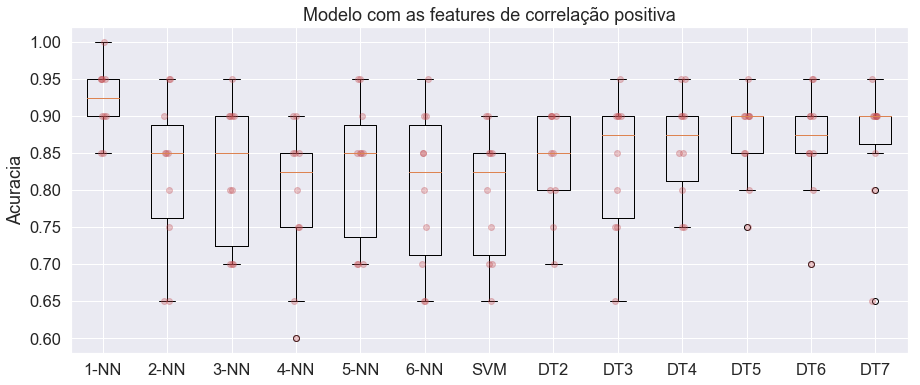

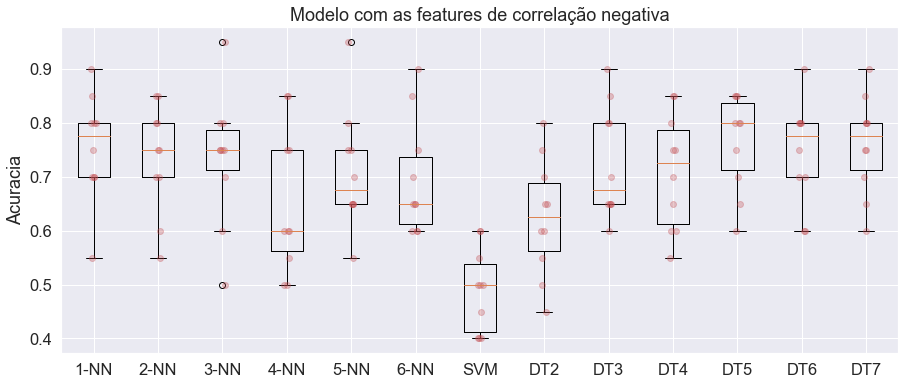

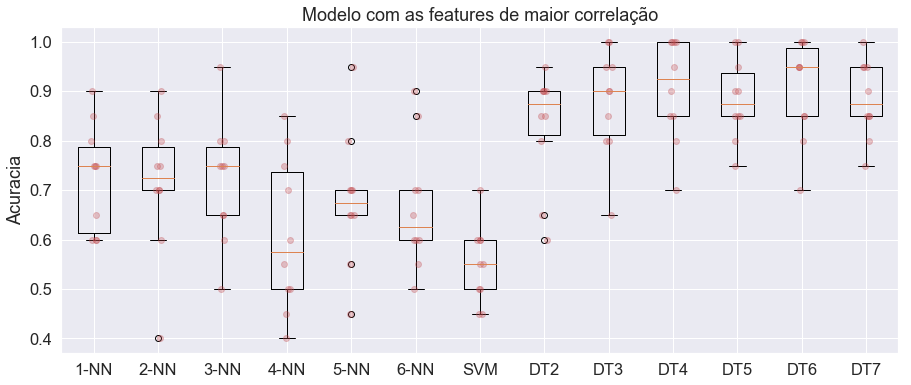

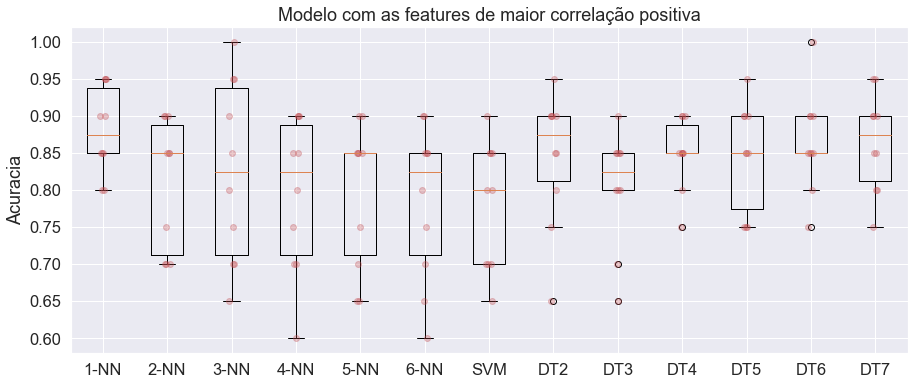

In [18]:
# Aplicamos a função de modelos
set_seed()
sns.set(font_scale=1.5)

# Selecionamos as colunas 
features_positive = [col for col in dfParkinson.columns if col not in ['name', 'status','HNR','MDVP:Fo(Hz)','MDVP:Flo(Hz)','MDVP:Fhi(Hz)']]
features_negative = [col for col in dfParkinson.columns if col in ['HNR','MDVP:Fo(Hz)','MDVP:Flo(Hz)','MDVP:Fhi(Hz)']]
features_max = [col for col in dfParkinson.columns if col in ['spread1','MDVP:Fo(Hz)','PPE','MDVP:RAP',
                                                              'MDVP:Fhi(Hz)','spread2','MDVP:Jitter(%)',
                                                              'MDVP:Shimer','MDVP:Flo(Hz)','D2','DFA']]
features_max_onlypositive = [col for col in dfParkinson.columns if col in ['spread1','PPE','MDVP:RAP',
                                                              'spread2','MDVP:Jitter(%)',
                                                              'MDVP:Shimer','D2','DFA']]
# Chamamos nossa função com os parâmetros
features = [features_positive,features_negative,features_max,features_max_onlypositive]
PRC = 0.2
titles = ["Modelo com as features de correlação positiva","Modelo com as features de correlação negativa",
         "Modelo com as features de maior correlação", "Modelo com as features de maior correlação positiva"]
acuracias, precisions, recalls, f1_scores = modelos(dfParkinsonEquilibrate,features,len(features),PRC, 10, titles)

De novo observamos as grandes diferenças que existem entre os diferentes modelos ao ter features diferentes e dados diferentes.

Além disso, podemos dizer que:

* Quando usamos todas as features com coeficiente positivo (no método corr()), o modelo tendo a melhor acurácia em mediana é o kNN com 1 vizinho. Além disso, a distribuição é bastante homogênea e todos os valores são maiores do que 0.85.

* Quando usamos todas as features com coeficiente negativo (no método corr()), o modelo tendo a melhor acurácia em mediana é o DT com altura 5. Porém, todos os resultados são piores do que os modelos anteriores pois essa acurácia maxima é de 0.8.

* Ao usar as features com coeficiente alto dadas pelo no método ExtraTreesClassifier(), obtemos que o modelo tendo a melhor acurácia em mediana é o DT com altura 6. Porém, alguns valores são inferiores a 0.8.

* Finalmente, ao usar todas as features com coeficiente alto (no método ExtraTreesClassifier()), mas que são positivos no método corr(), obtemos que o modelo tendo a melhor acurácia em mediana é o DT com alturas 2 ou 7. Porém, as duas são heterogêneas e têm valores inferiores a 0.8. Os kNN com 1 vizinho parecem um bom compromisso, pois têm uma distribuiçao mais homogênea e todos os valores acima de 0.8.

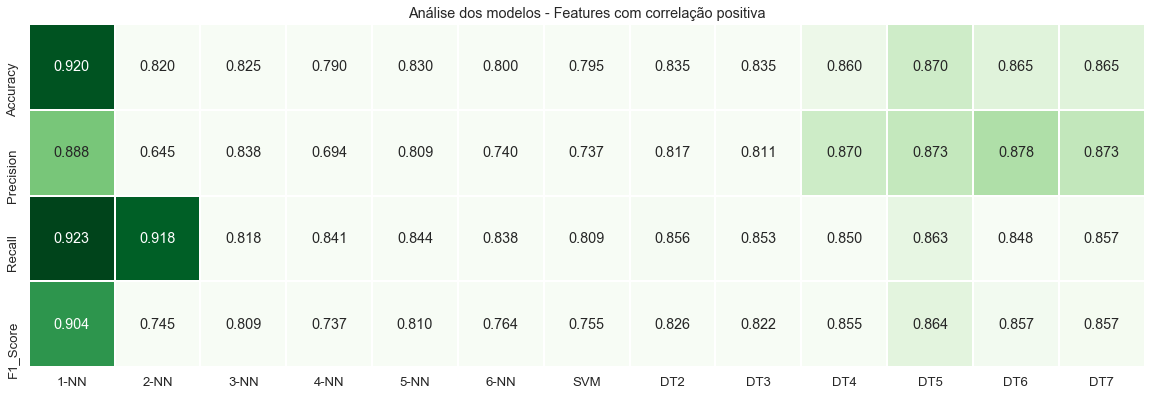

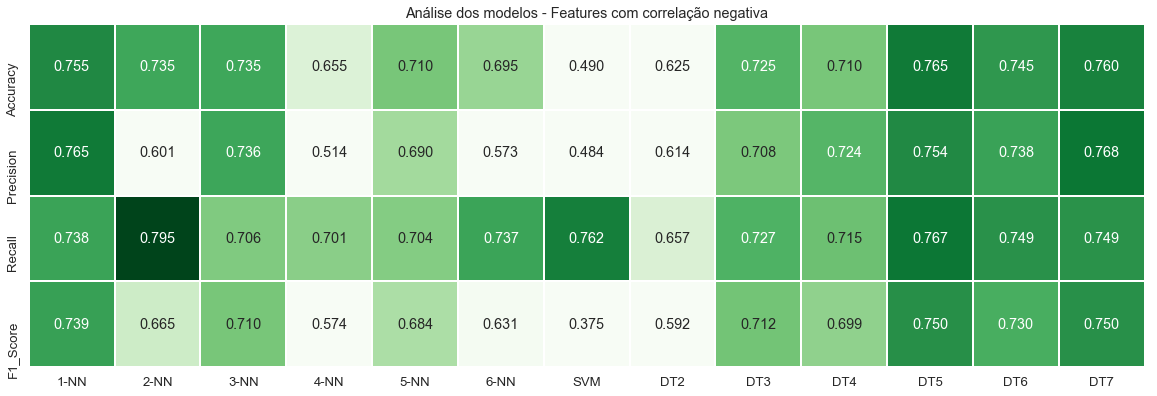

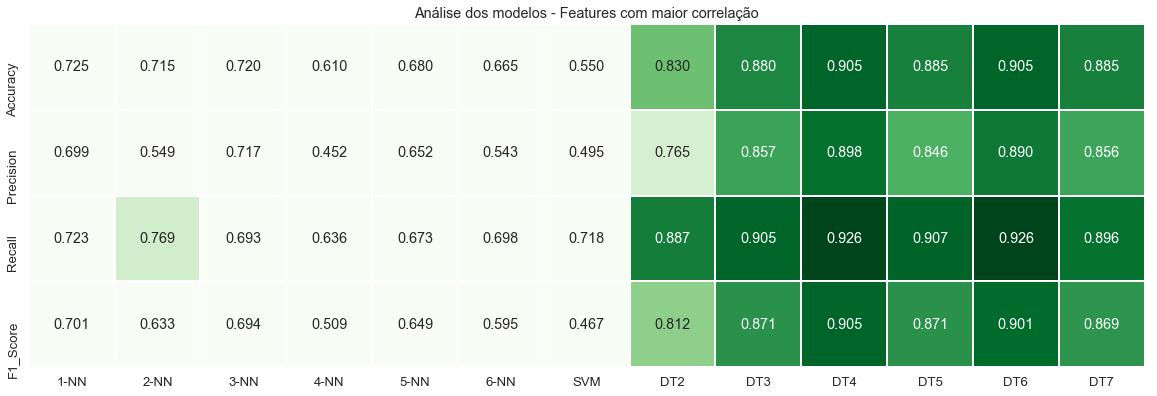

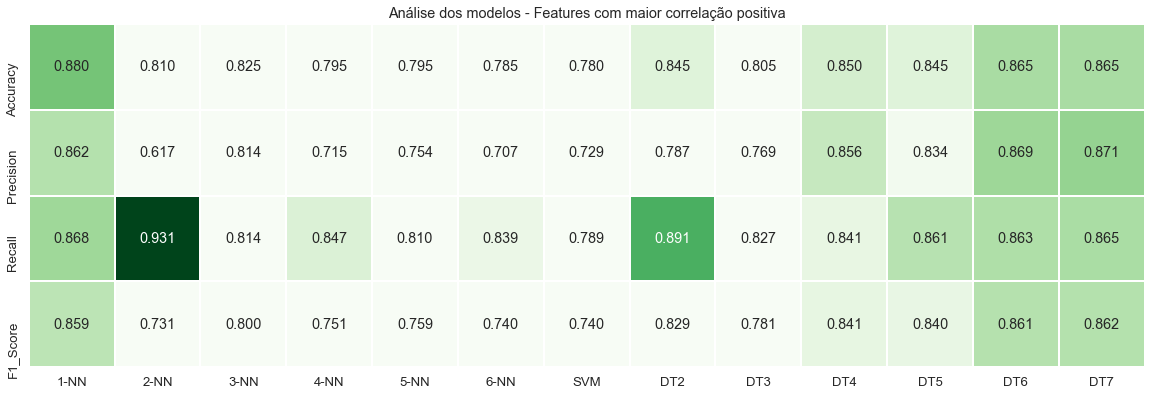

In [19]:
analise_modelos_obtidos(0,'Análise dos modelos - Features com correlação positiva')
analise_modelos_obtidos(1,'Análise dos modelos - Features com correlação negativa')
analise_modelos_obtidos(2,'Análise dos modelos - Features com maior correlação')
analise_modelos_obtidos(3,'Análise dos modelos - Features com maior correlação positiva')

A primeira coisa que podemos observar é que as maiores acurácias médias sao obtidas com:
* O kNN com 1 vizinho para as features com correlação positiva
* O DT de altura 5 para as features com correlação negativa
* O DT de altura 4 ou DT de altura 6 para as features com maiores coeficientes obtidos pelo método ExtraTreesClassifier().
* O kNN com 1 vizinho para as features com maiores coeficientes obtidos pelo método ExtraTreesClassifier() tendo coeficientes positivos no corr().

A melhor acuracia média (0.920) é obtida com o kNN com 1 vizinho e as features com correlação positiva no método corr() e um dataset equilibrado para criar o modelo. Essa acurácia média é superior à maior média obtida na primeira parte do trabalho (0.879) e na segunda (0.895).

Neste caso, as maiores precisions já não são obtidas com o modelo SVM e isso faz sentido se pensamos que os nossos dados são mais equilibrados agora.

Observamos que o melhor recall é obtido com o modelo 2-NN usando as features com maiores coeficientes obtidos pelo método ExtraTreesClassifier() (0.931), mas os recall do kNN com 1 vizinho e as features com correlação positiva no método corr() já é muito bom (0.923).

Finalmente, o F1_score, medida de avaliação do modelo, é maior no modelo Decision Tree de altura 4 e as features com maiores coeficientes obtidos pelo método ExtraTreesClassifier(). (0.905) mas no modelo kNN com 1 vizinho e as features com correlação positiva no método corr() é quase idêntico (0.904).

Em conclusão, parece que esse modelo modelo kNN com 1 vizinho e as features com correlação positiva no método corr() seria o melhor modelo se tivessemos que usar os valores médios.

Esse modelo tem também uma boa distribuição das acurácias!

# Considerações finais

### Melhor modelo

Entre todos os modelos desenvolvidos, parece que o melhor foi obtido ao:
* Treinar o nosso modelo com um dataset equilibrado, porém mais pequeno
* Usando as features com correlação positiva dadas pelo método corr()
* Com o modelo de kNN e 1 vizinho

### Comentários

Porém,

* Temos que ser cientes que temos poucos dados, sobre tudo em nosso "melhor" modelo, que somente tem 96 medições. As acurácias e outros dados de análise são boas demais, o que faz pensar que podemos ter um pouco de overfitting.

* Poderíamos ter feito outros modelos, por exemplo kNN até 11 vizinhos e DT até altura 11 ou 22.

* Poderíamos ter plotado o boxplot dos recall ou f1_score para ter uma melhor visibilidade sobre as distribuições dos resultados

* Temos que pensar que o lado 'random' de todos os modelos segue sendo controlado pela seed, o que perde um pouco de aleatoriedade.